<a href="https://colab.research.google.com/github/benjaminsw/MResDissertation/blob/main/LDA_with_shrikage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install split_folders

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


### get data

In [ ]:
!git clone https://github.com/benjaminsw/COVID-19.git

fatal: destination path 'COVID-19' already exists and is not an empty directory.


In [ ]:
# rename folder to remove white space
!mv 'COVID-19/X-Ray Image DataSet' 'COVID-19/X-Ray_Image_DataSet'

# list files in directory
!ls COVID-19/X-Ray_Image_DataSet

mv: cannot stat 'COVID-19/X-Ray Image DataSet': No such file or directory
Covid-19  No_findings  Pneumonia


### import library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

import joblib
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

import splitfolders
import cv2

from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

### count files

In [ ]:
import os
import pathlib

def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))
            

### split data

In [ ]:
splitfolders.ratio('/content/COVID-19/X-Ray_Image_DataSet', output="output", seed=2020, ratio=(.6, 0.2,0.2)) 

Copying files: 1125 files [00:05, 199.19 files/s]


In [ ]:
count_files('/content/output/train') # data_dir is the directory for files count.

There are 400 files in No_findings
There are 400 files in Pneumonia
There are 100 files in Covid-19


In [ ]:
count_files('/content/output/val')

There are 100 files in No_findings
There are 100 files in Pneumonia
There are 25 files in Covid-19


### Merging two folders

In [ ]:
import shutil, sys  

#recursively merge two folders including subfolders
def mergefolders(root_src_dir, root_dst_dir):
    for src_dir, dirs, files in os.walk(root_src_dir):
        dst_dir = src_dir.replace(root_src_dir, root_dst_dir, 1)
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        for file_ in files:
            src_file = os.path.join(src_dir, file_)
            dst_file = os.path.join(dst_dir, file_)
            if os.path.exists(dst_file):
                os.remove(dst_file)
            shutil.copy(src_file, dst_dir)


In [ ]:
# merge train and val 
mergefolders('/content/output/val', '/content/output/train')

# count 
count_files('/content/output/train') 

There are 400 files in No_findings
There are 400 files in Pneumonia
There are 100 files in Covid-19


### read data


ref: https://developpaper.com/detailed-explanation-of-the-use-of-imagefolder-in-pytorch/

In [ ]:
from torchvision import transforms as T
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder

In [ ]:
train_path = '/content/output/train/'
val_path = '/content/output/val/'
test_path = '/content/output/test/'

{'Covid-19': 0, 'No_findings': 1, 'Pneumonia': 2}
[('/content/output/train/Covid-19/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg', 0), ('/content/output/train/Covid-19/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg', 0), ('/content/output/train/Covid-19/1-s2.0-S0140673620303706-fx1_lrg.jpg', 0), ('/content/output/train/Covid-19/1-s2.0-S0929664620300449-gr2_lrg-a.jpg', 0), ('/content/output/train/Covid-19/1-s2.0-S0929664620300449-gr2_lrg-b.jpg', 0), ('/content/output/train/Covid-19/1-s2.0-S0929664620300449-gr2_lrg-c.jpg', 0), ('/content/output/train/Covid-19/1-s2.0-S0929664620300449-gr2_lrg-d.jpg', 0), ('/content/output/train/Covid-19/1-s2.0-S1684118220300608-main.pdf-001.jpg', 0), ('/content/output/train/Covid-19/1-s2.0-S1684118220300608-main.pdf-002.jpg', 0), ('/content/output/train/Covid-19/1-s2.0-S1684118220300682-main.pdf-002-a1.png', 0), ('/content/output/train/Covid-19/1-s2.0-S1684118220300682-main.pdf-002-a2.png', 0), ('/content/output/train/Covid-19/1-s2.0-S1684118220300682-main.pdf-00

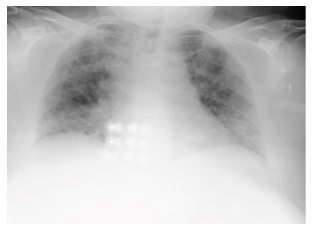

In [ ]:
dataset = ImageFolder(train_path)

#The picture in train folder corresponds to {'Covid-19': 0, 'No_findings': 1, 'Pneumonia': 2}
print(dataset.class_to_idx)

#Paths of all pictures and corresponding labels
print(dataset.imgs)

#There is no transform, so the PIL image object is returned
#Print (dataset [0] [1]) # the first dimension is the number of images, the second dimension is 1, and label is returned
#Print (dataset [0] [0]) # is 0 and returns picture data
plt.imshow(dataset[0][0])
plt.axis('off')
plt.show()

torch.Size([3, 64, 64])


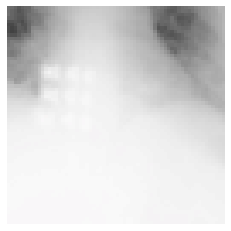

In [ ]:
normalize = T.Normalize(mean=[0.4, 0.4, 0.4], std=[0.2, 0.2, 0.2])
transform = T.Compose([
     T.RandomResizedCrop(64), #256
     T.RandomHorizontalFlip(),
     T.ToTensor(),
     normalize,
])
training_set = ImageFolder(train_path, transform=transform)
test_set = ImageFolder(test_path, transform=transform)

#In deep learning, the picture data is generally saved as cxhxw, that is, the number of channels x the picture height x the picture width
print(training_set[0][0].size())

to_img = T.ToPILImage()
#0.2 and 0.4 are approximations of the standard deviation and mean
a=to_img(training_set[0][0]*0.2+0.4)
plt.imshow(a)
plt.axis('off')
plt.show()

In [ ]:
training_set

Dataset ImageFolder
    Number of datapoints: 900
    Root location: /content/output/train/
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(64, 64), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4, 0.4, 0.4], std=[0.2, 0.2, 0.2])
           )

In [ ]:
train_target_array = np.array(training_set.targets)
test_target_array = np.array(test_set.targets)

In [ ]:
train_data_array = np.array([training_set[i][0].numpy().flatten() for i in range(0, len(train_target_array))])
test_data_array = np.array([test_set[i][0].numpy().flatten() for i in range(0, len(test_target_array))])

In [ ]:
# use lots of memory
#import pandas as pd

#traning_df = pd.DataFrame(traing_array)
#traning_df.head()

### fit LDA

ref: https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

n_componentsint, default=None
Number of components (<= min(n_classes - 1, n_features)) for dimensionality reduction. If None, will be set to min(n_classes - 1, n_features). This parameter only affects the **transform** method.

reading: https://scikit-learn.org/stable/modules/lda_qda.html#lda-qda

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(solver = 'svd')
clf.fit(train_data_array, train_target_array)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

### predict

In [ ]:
predict_test_data_array = clf.predict(test_data_array)

### accuracy and confusion matrix

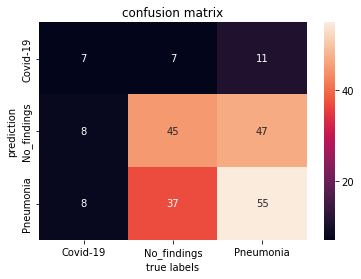

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_target_array, predict_test_data_array)
# 'Covid-19': 0, 'No_findings': 1, 'Pneumonia': 2
x_axis_labels = ['Covid-19', 'No_findings', 'Pneumonia']
y_axis_labels = ['Covid-19', 'No_findings', 'Pneumonia']
f = sns.heatmap(cm, annot=True, fmt='d', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
f.set(title = 'confusion matrix',
      xlabel = 'true labels',
      ylabel = 'prediction',)
sns.set(font_scale=2)

In [ ]:
from sklearn.metrics import classification_report

target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(test_target_array, predict_test_data_array, target_names=target_names))

              precision    recall  f1-score   support

    Covid-19       0.30      0.28      0.29        25
 No_findings       0.51      0.45      0.48       100
   Pneumonia       0.49      0.55      0.52       100

    accuracy                           0.48       225
   macro avg       0.43      0.43      0.43       225
weighted avg       0.47      0.48      0.47       225



# fit LDA with shrinkage

In [ ]:
clf = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 'auto') # current 256 but previous version was 128
clf.fit(train_data_array, train_target_array)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
                           solver='lsqr', store_covariance=False, tol=0.0001)

### predict

In [ ]:
predict_test_data_array = clf.predict(test_data_array)

### accuracy and confusion matrix

matrix for:  Covid-19
	 Accuracy :  0.889
	 Sensitivity :  0.24
	 Specificity :  0.97
	 F1-score :  0.324
matrix for:  No_findings
	 Accuracy :  0.578
	 Sensitivity :  0.54
	 Specificity :  0.608
	 F1-score :  0.532
matrix for:  Pneumonia
	 Accuracy :  0.556
	 Sensitivity :  0.55
	 Specificity :  0.56
	 F1-score :  0.524


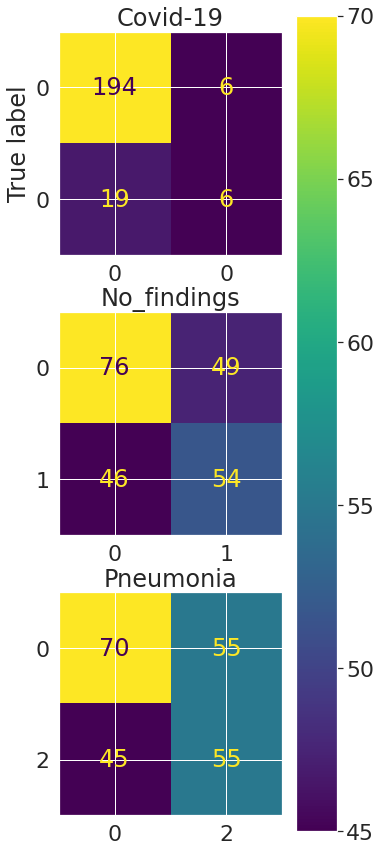

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f, axes = plt.subplots(3, 1, figsize=(5, 15))
axes = axes.ravel()
for i in range(3):
    disp = ConfusionMatrixDisplay(confusion_matrix(test_target_array==i,
                                                   predict_test_data_array==i),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(target_names[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

    print('matrix for: ', target_names[i])
    cm1 = confusion_matrix(test_target_array==i, predict_test_data_array==i)
    #####from confusion matrix calculate accuracy
    total1=sum(sum(cm1))
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('\t Accuracy : ', round(accuracy1,3))

    sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('\t Sensitivity : ', sensitivity1 )

    specificity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('\t Specificity : ', specificity1)

    F1_score = cm1[1,1]/(cm1[1,1] + 0.5*(cm1[1,0]+cm1[0,1]))
    print('\t F1-score : ', round(F1_score,3))

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()